In [150]:
import os
import numpy as np
import torch
import scipy.io
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import CountVectorizer
import numpy as np
from scipy import sparse
from typing import Tuple, List
import re
import string
from gensim.models import Word2Vec, KeyedVectors
import torch.nn.functional as F
from torch import nn
from torch import optim
import math
from typing import List
from torch import optim
import matplotlib.pyplot as plt

In [151]:
train_data = fetch_20newsgroups(subset='train')
test_data = fetch_20newsgroups(subset='test')

In [110]:
#Removing special characters
train_docs = [re.findall(r'''[\w']+|[.,!?;-~{}`´_<=>:/@*()&'$%#"]''', train_data.data[doc]) for doc in range(len(train_data.data))]
test_docs = [re.findall(r'''[\w']+|[.,!?;-~{}`´_<=>:/@*()&'$%#"]''', test_data.data[doc]) for doc in range(len(test_data.data))]

def contains_punctuation(w):
    return any(char in string.punctuation for char in w)

def contains_numeric(w):
    return any(char.isdigit() for char in w)

total_docs = train_docs + test_docs

#Converting words to lowercase and eliminating the words with numbers
total_docs = [[word.lower() for word in total_docs[doc] if not contains_punctuation(word)] for doc in range(len(total_docs))]
total_docs = [[word for word in total_docs[doc] if not contains_numeric(word)] for doc in range(len(total_docs))]

#Removing words with single character
total_docs = [[word for word in total_docs[doc] if len(word)>1] for doc in range(len(total_docs))]
total_docs = [" ".join(total_docs[doc]) for doc in range(len(total_docs))]

In [152]:
def token_counts_split(bow_data, size):
    tokens = [[w for w in bow_data[doc, :].indices] for doc in range(size)]
    counts = [[c for c in bow_data[doc, :].data] for doc in range(size)]
    return tokens, counts

def create_bow_representation(doc_indices, words, dataset_size, vocab_length):
    return sparse.coo_matrix(([1] * len(doc_indices), (doc_indices, words)), 
        shape=(dataset_size, vocab_length)).tocsr()

def document_indices(documents):
    aux = [[j for i in range(len(doc))] for j, doc in enumerate(documents)]
    return [int(x) for y in aux for x in y]

def data_preprocessing(total_docs, min_df, max_df, train_factor=1.0):
    
    #Vectorized count reperestion of words in the documents
    vectorizer = CountVectorizer(min_df=min_df, max_df=max_df)
    v_docs = vectorizer.fit_transform(total_docs)
    docs = [[word for word in document.split() if word not in vectorizer.stop_words_] for document in total_docs]
    v_docs = v_docs.sign()

    #Creating the vocaubalary for the dataset
    sum_cts = v_docs.sum(axis=0)
    vocab_length = sum_cts.shape[1]
    sum_array = np.zeros(vocab_length, dtype=int)
    for w in range(vocab_length):
        sum_array[w] = sum_cts[0, w]
    word2id = dict([(w, vectorizer.vocabulary_.get(w)) for w in vectorizer.vocabulary_])
    id2word = dict([(vectorizer.vocabulary_.get(w), w) for w in vectorizer.vocabulary_])
    index_sort = np.argsort(sum_array)
    vocab = [id2word[index_sort[c]] for c in range(vocab_length)]
    
    #Calculating tarin and test size 
    train_size = int(np.floor(train_factor * v_docs.shape[0]))
    test_size = int(v_docs.shape[0] - train_size)
    #Computing permutation for random reordering of the documents
    index_rand = np.random.permutation(v_docs.shape[0]).astype(int)

    #Considering only the words present in training data
    vocab = list(set([w for i in range(train_size) 
                      for w in docs[index_rand[i]] if w in word2id]))
    word2id = dict([(w, i_d) for i_d, w in enumerate(vocab)])
    id2word = dict([(i_d, w) for i_d, w in enumerate(vocab)])

    #Spliting into train and test data
    train_data = [[word2id[w] for w in docs[index_rand[i]] if w in word2id] for i in range(train_size)]
    test_data = [[word2id[w] for w in docs[index_rand[i + train_size]] if w in word2id] for i in range(test_size)]
    train_data = [doc for doc in train_data if doc != []]
    test_data = [doc for doc in test_data if doc != []]
    test_data = [doc for doc in test_data if len(doc) > 1]
    test_data1 = [[w for i, w in enumerate(doc) if i <= len(doc) / 2.0 - 1] for doc in test_data]
    test_data2 = [[w for i, w in enumerate(doc) if i > len(doc) / 2.0 - 1] for doc in test_data]

    #Words present in tarin and test data
    train_words = [w for doc in train_data for w in doc]
    test_words1 = [w for doc in test_data1 for w in doc]
    test_words2 = [w for doc in test_data2 for w in doc]

    train_indices = document_indices(train_data)
    test_indices1 = document_indices(test_data1)
    test_indices2 = document_indices(test_data2)

    #Creating a bag of word reperestation for train and test data
    train_bow = create_bow_representation(train_indices, train_words, len(train_data), len(vocab))
    test_bow1 = create_bow_representation(test_indices1, test_words1, len(test_data1), len(vocab))
    test_bow2 = create_bow_representation(test_indices2, test_words2, len(test_data1), len(vocab))

    #Spliting data into token and count reperestation of the data and storing it in a dictionary
    train_tokens, train_counts = token_counts_split(train_bow, len(train_data))
    test_tokens1, test_counts1 = token_counts_split(test_bow1, len(test_data1))
    test_tokens2, test_counts2 = token_counts_split(test_bow2, len(test_data2))
    train_dataset = {
        'tokens': np.array([[np.array(d) for d in train_tokens]], dtype=object).squeeze(),
        'counts': np.array([[np.array(d) for d in train_counts]], dtype=object).squeeze(),
    }

    test_dataset = {
        'test1': {
            'tokens': np.array([[np.array(d) for d in test_tokens1]], dtype=object).squeeze(),
            'counts': np.array([[np.array(d) for d in test_counts1]], dtype=object).squeeze(),
        },
        'test2': {
            'tokens':np.array([[np.array(d) for d in test_tokens1]], dtype=object).squeeze(),
            'counts': np.array([[np.array(d) for d in test_counts1]], dtype=object).squeeze(),
        }
    }

    return vocab, train_dataset, test_dataset

In [112]:
#Data Preprocessing, train and test data split, creating vocabulary
vocab, train_data, test_data = data_preprocessing(total_docs, min_df=10, max_df=0.70, train_factor=0.85)

In [113]:
#creating the dense representation of bow for the given batch size
def get_batch(doc_tokens, doc_counts, ind, vocab_size):
    
    docs_batch = np.zeros((len(ind), vocab_size))

    for k, doc_id in enumerate(ind):
        doc = doc_tokens[doc_id]
        count = doc_counts[doc_id]
        
        if len(doc) == 1:
            doc = [doc.squeeze()]
            count = [count.squeeze()]
        else:
            doc = doc.squeeze()
            count = count.squeeze()
            
        if doc_id != -1:
            for l, word in enumerate(doc):
                docs_batch[k, word] = count[l]
                
    docs_batch = torch.from_numpy(docs_batch).float()
    return docs_batch


In [114]:
class Model(nn.Module):
    def __init__(self, vocab_length, hidden_layer_size, total_topics, rho_length, dout=0.5, embeddings=None, train_embeddings=True):
        super(Model, self).__init__()

        
        self.vocab_length = vocab_length
        self.hidden_layer_size = hidden_layer_size
        self.total_topics = total_topics
        self.rho_length = rho_length
        self.dropout = nn.Dropout(dout)
        self.train_embeddings = train_embeddings
        
        #Linear layer for computing the topic embeddings
        self.alphas = nn.Linear(rho_length, total_topics, bias=False)
        
        #Assigning word embeddings or creating the linear layer in case of training the word embeddings
        if self.train_embeddings:
            self.rho = nn.Linear(rho_length, vocab_length, bias=False)
        else:
            self.rho = embeddings.clone().float()

        #Creating the layers for encoder
        self.q_theta = nn.Sequential(
            nn.Linear(vocab_length, hidden_layer_size),
            nn.ReLU(),
            nn.Linear(hidden_layer_size, hidden_layer_size),
            nn.ReLU(),
        )
        #Layer for latent space represtation of the theta
        self.mu_theta = nn.Linear(hidden_layer_size, total_topics, bias=True)
        self.logsigma_theta = nn.Linear(hidden_layer_size, total_topics, bias=True)

    #Calculation the beta that topic_word distribution by taking product of topic embeddings and word embeddings
    def compute_beta(self):
        if self.train_embeddings:
            embeddings_product = self.alphas(self.rho.weight)
        else:
            embeddings_product = self.alphas(self.rho)
        beta = F.softmax(embeddings_product, dim=0).transpose(1, 0)
        return beta
    
    #Reparameterization and smapling from the distribuation
    def reparameterization(self, mu, logvar):
        if self.training:
            sd = torch.exp(0.5 * logvar)
            s = torch.randn_like(sd)
            return s.mul_(sd).add_(mu)
        else:
            return mu
    
    #Encoder part of the variational Auto encoder, for calculating mu and log sigma of theta distribuation
    def encoder(self, X_norm):
        q_theta = self.q_theta(X_norm)
        q_theta = self.dropout(q_theta)
        mu = self.mu_theta(q_theta)
        logsigma = self.logsigma_theta(q_theta)
        kl_term =  -0.5 * torch.sum(1 + logsigma - mu.pow(2) - logsigma.exp(), dim=-1).mean()
        sample = self.reparameterization(mu, logsigma)
        theta = F.softmax(sample, dim=-1)
        return theta, kl_term
    
    #Decoder for reconstruction of the input by taking product of topic and word distributions
    def decoder(self, theta, beta):
        X_reconstructed = torch.log(torch.mm(theta, beta) + 1e-6)
        return X_reconstructed

    def forward(self, X, X_norm, theta=None):
        
        if theta is None:
            theta, kl_term = self.encoder(X_norm)
        else:
            kl_term = None
        beta_matrix = self.compute_beta()
        
        X_reconstructed = self.decoder(theta, beta_matrix)
        reconstruction_loss = -(X_reconstructed * X).sum(1).mean()
        #Calculating the negative ELBO
        loss_function = reconstruction_loss + kl_term
        return loss_function, reconstruction_loss

In [143]:

class ETM(object):

    def __init__(self, vocab, total_topics = 10, iterations = 20, rho_length = 300, embeddings = None, train_embeddings = False, 
                 hidden_layer_size = 800, learning_rate = 0.005, batch_size = 1000, weight_decay = 1.2e-6, top_words = 10, log_interval = 2, dout = 0.0):
        
        self.vocab = vocab
        self.total_topics = total_topics
        self.iterations = iterations
        self.rho_length = rho_length
        self.train_embeddings = train_embeddings
        self.hidden_layer_size = hidden_layer_size
        self.learning_rate = learning_rate
        self.batch_size = batch_size
        self.weight_decay = weight_decay
        self.top_words = top_words
        self.log_interval = log_interval
        self.vocab_length = len(self.vocab)
        self.dropout = dout
        self.negative_ELBO = []
        self.Recons_loss = []
        if self.train_embeddings:
            self.embeddings = None  
        else:
            self.embeddings = self.process_pretrained_embeddings(embeddings)
        
        
        np.random.seed(0)
        torch.manual_seed(0)
        if torch.cuda.is_available():
            torch.cuda.manual_seed(0)
        
        self.model = Model(
            self.vocab_length,
            self.hidden_layer_size,
            self.total_topics,
            self.rho_length,
            self.dropout,
            self.embeddings,
            self.train_embeddings)
        self.optimizer = optim.Adam(self.model.parameters(), lr=self.learning_rate, weight_decay=self.weight_decay)


    def train_model(self, itr, train_data_tokens, train_data_counts):
        self.model.train()
        count = 0
        total_rec_loss = 0
        total_loss = 0
        
        #Spliting the data into batches
        doc_indices = torch.randperm(len(train_data_tokens))
        doc_indices = torch.split(doc_indices, self.batch_size)
        
        for doc_id in doc_indices:
            self.optimizer.zero_grad()
            self.model.zero_grad()
            batch = get_batch(train_data_tokens, train_data_counts, doc_id, self.vocab_length)
            #Normalizing the bow representation
            batch_data_norm = batch / batch.sum(1).unsqueeze(1)
            loss_function, reconstruction_loss = self.model(batch, batch_data_norm)
            loss_function.backward()
            self.optimizer.step()
            total_rec_loss += torch.sum(reconstruction_loss).item()
            total_loss += torch.sum(loss_function).item()
            count += 1
        #Calculating cummulative reconstruction loss and negative ELBO 
        total_rec_loss = round(total_rec_loss / count, 3)
        total_loss = round(total_loss / count, 3)
        self.negative_ELBO.append(total_loss)
        self.Recons_loss.append(total_rec_loss)
        if itr % 10 == 0:
             print('Iteration {} - Rec loss: {} - NELBO: {}'.format(itr, total_rec_loss, total_loss))

        
    def fit(self, train_data, test_data=None):
       
        train_data_tokens = train_data['tokens']
        train_data_counts = train_data['counts']
        
        #Displaying topic before training
        with torch.no_grad():
            topics = []
            beta_matrix = self.model.compute_beta()
            for t in range(self.total_topics):
                words_token = list(beta_matrix[t].numpy().argsort()[-10:][::-1])
                words = [self.vocab[i] for i in words_token]
                topics.append(words)
            print(f'Topics before training: {topics}')
        
        #Training the model
        for itr in range(1, self.iterations):
            self.train_model(itr, train_data_tokens, train_data_counts)
         
        #Displaying topic after training
        with torch.no_grad():
            topics = []
            beta_matrix = self.model.compute_beta()
            for t in range(self.total_topics):
                words_token = list(beta_matrix[t].numpy().argsort()[-10:][::-1])
                words = [self.vocab[i] for i in words_token]
                topics.append(words)
            print(f'Topics after training: {topics}')

        return self
    
    
    def process_pretrained_embeddings(self, embeddings):
        embeddings_array = np.zeros((self.vocab_length, self.rho_length))
        
        #Intializing the embeddings and assigning the random vector incase abscence of given word
        for k, word in enumerate(self.vocab):
            try:
                embeddings_array[k] = embeddings[word]
            except KeyError:
                embeddings_array[k] = np.random.normal(scale=0.6, size=(self.emb_size, ))
        return torch.from_numpy(embeddings_array)
    
    def calculate_perplexity(self, test_data):
        test_tokens1 = test_data['test1']['tokens']
        test_tokens2 = test_data['test2']['tokens']

        test_counts1 = test_data['test1']['counts']
        test_counts2 = test_data['test2']['counts']
        self.model.eval()
        with torch.no_grad():
            count = 0
            total_loss = 0
            beta = self.model.compute_beta()
            doc_indices = torch.split(torch.tensor(range(len(test_tokens1))), self.batch_size)
            for doc_id in doc_indices:
                #Calculating the distribuation on first half of the test data: Considered as observed data
                batch1 = get_batch(test_tokens1, test_counts1, doc_id, self.vocab_length)
                batch_data_norm1 = batch1 / batch1.sum(1).unsqueeze(1)
                theta, _ = self.model.encoder(batch_data_norm1)
                
                #Calculating the liklihood of document completion for the second half of the test data
                batch2 = get_batch(test_tokens2, test_counts2, doc_id, self.vocab_length)
                batch2_reconstructed = self.model.decoder(theta, beta)
                reconstruction_loss = -(batch2_reconstructed * batch2).sum(1)
                loss = (reconstruction_loss / batch2.sum(1)).mean().item()
                total_loss += loss
                count += 1
            perplexity = round(math.exp(total_loss/count), 2)
            return perplexity
    
    def calculate_topic_diversity(self):
        self.model.eval()
        top_words = 20
        with torch.no_grad():
            beta = self.model.compute_beta().numpy()
            matrix = np.zeros((self.total_topics, top_words))
            for t in range(self.total_topics):
                sorted_vector = beta[t, :].argsort()
                index = sorted_vector[-top_words: ][: : -1]
                matrix[t, :] = index
            unique_count = len(np.unique(matrix))
            #Calculating the percentage of unique words over all the topics
            topic_diversity = unique_count / (top_words * self.total_topics)
            return topic_diversity


    #Function calculates the topic word distribution after training, if required
    def calculate_word_distribution(self):
        self.model.eval()
        with torch.no_grad():
            return self.model.compute_beta()


    #Function calculates the document topic distribution after training, if required
    def calculate_topic_distribution(self, train_data):
    
        self.model.eval()
        
        train_tokens = train_data['tokens']
        train_counts = train_data['counts']
        distribution = []
        with torch.no_grad():
            count = 0
            total_loss = 0
            doc_indices = torch.split(torch.tensor(range(len(train_tokens))), self.batch_size)
            for doc_id in doc_indices:
                batch = get_batch(train_tokens, train_counts, doc_id, self.vocab_length)
                batch_data_norm = batch / batch.sum(1).unsqueeze(1)
                theta, _ = self.model.encoder(batch_data_norm)
                distribution.append(theta)
            distribution = torch.cat(tuple(distribution), 0)
            return distribution


In [116]:
def pretrained_word_embeddings(data, rho_d=300, min_ct=1, sg=1, workers=25, neg_samples=10, w_size=4, epochs=50):
    
    sentences = [doc.split() for doc in data]
    #Pre-training the word embeddings
    model = Word2Vec(
        sentences,
        min_count=min_ct,
        sg=sg,
        vector_size=rho_d,
        epochs=epochs,
        workers=workers,
        negative=neg_samples,
        window=w_size)
    embeddings = model.wv

    return embeddings

In [117]:
embeddings = pretrained_word_embeddings(total_docs)

In [124]:
#Training and evaluating the model for min_df = 10 for 50 iterations
ETM_Model1 = ETM(vocab, total_topics=8, iterations=50, embeddings=embeddings, train_embeddings=False)
ETM_Model1.fit(train_data) 

Topics before training: [['af', 'det', 'beaverton', 'uc', 'tor', 'pict', 'hardest', 'robot', 'jp', 'strawberry'], ['bu', 'avoiding', 'comets', 'mathematics', 'harper', 'incomplete', 'winmarks', 'dammit', 'unbiased', 'ml'], ['iq', 'sj', 'wang', 'acsu', 'rebound', 'masks', 'dakota', 'maryland', 'bargaining', 'eecs'], ['rat', 'pillion', 'diana', 'usd', 'bg', 'philosopher', 'advise', 'louisiana', 'quantum', 'confined'], ['ref', 'diving', 'cellar', 'bullets', 'arsenal', 'noel', 'nervous', 'disasters', 'reputation', 'grip'], ['hulk', 'samuelsson', 'destroying', 'thereby', 'majors', 'corpses', 'ballot', 'thereafter', 'arrest', 'preparing'], ['expecting', 'zoology', 'oulu', 'asuacad', 'springfield', 'callison', 'golden', 'synthetic', 'hits', 'monthly'], ['dg', 'doh', 'pit', 'ace', 'batman', 'quest', 'uic', 'kelvin', 'inland', 'wolverine']]
Iteration 10 - Rec loss: 1602.448 - NELBO: 1609.894
Iteration 20 - Rec loss: 1572.559 - NELBO: 1581.838
Iteration 30 - Rec loss: 1642.889 - NELBO: 1652.317


<function matplotlib.pyplot.show(close=None, block=None)>

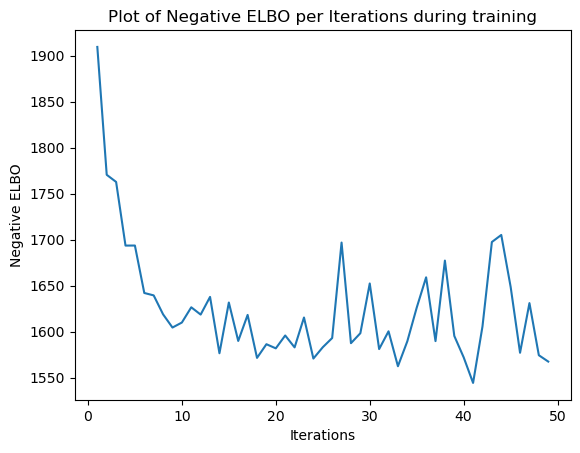

In [127]:
iterations = []
for itr in range(1, 50):
    iterations.append(itr)
plt.plot(iterations, ETM_Model1.negative_ELBO)
plt.title('Plot of Negative ELBO per Iterations during training') 
plt.ylabel('Negative ELBO')
plt.xlabel('Iterations')
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

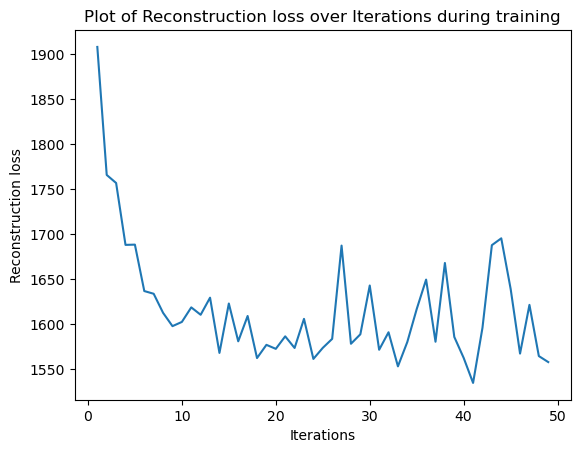

In [128]:
iterations = []
for itr in range(1, 50):
    iterations.append(itr)
plt.plot(iterations, ETM_Model1.Recons_loss)
plt.title('Plot of Reconstruction loss over Iterations during training') 
plt.ylabel('Reconstruction loss')
plt.xlabel('Iterations')
plt.show

In [144]:
#Training and evaluating the model for different vocabulary size for 50 iterations
iterations = 50
min_df = [100, 50, 20, 10, 5, 2]
perplexities = []
topic_diversities = []
vocab_sizes = []
for i in range(len(min_df)):
    print(f'For minimum document frequency: {min_df[i]}\n')
    vocab, train_data, test_data = data_preprocessing(total_docs, min_df=min_df[i], max_df=0.70, train_factor=0.85)
    ETM_Model2 = ETM(vocab, total_topics=8, iterations=iterations, embeddings=embeddings, train_embeddings=False)
    ETM_Model2.fit(train_data)
    pp = ETM_Model2.calculate_perplexity(test_data)
    td = ETM_Model2.calculate_topic_diversity()
    perplexities.append(pp)
    topic_diversities.append(td)
    vocab_sizes.append(len(vocab))
    print('\n')

For minimum document frequency: 100

Topics before training: [['uc', 'terrorists', 'log', 'cal', 'irvine', 'msu', 'cmu', 'lawrence', 'leads', 'purdue'], ['bu', 'mathematics', 'cleveland', 'panix', 'std', 'coast', 'object', 'displays', 'percentage', 'falls'], ['maryland', 'rpi', 'stanford', 'fm', 'du', 'portal', 'iv', 'amateur', 'delaware', 'greg'], ['quantum', 'ucsd', 'genesis', 'carter', 'ex', 'dare', 'nz', 'baby', 'gods', 'showed'], ['soldiers', 'arms', 'balls', 'plane', 'blue', 'cis', 'loop', 'diet', 'funds', 'entitled'], ['providing', 'spring', 'signs', 'granted', 'hits', 'holds', 'shuttle', 'judge', 'interests', 'civil'], ['golden', 'hits', 'split', 'tuesday', 'bryan', 'lake', 'healthy', 'optilink', 'dale', 'psuvm'], ['hq', 'expo', 'industrial', 'uunet', 'gmt', 'chemistry', 'howard', 'pitt', 'useragent', 'oz']]
Iteration 10 - Rec loss: 1204.236 - NELBO: 1209.179
Iteration 20 - Rec loss: 1149.01 - NELBO: 1155.203
Iteration 30 - Rec loss: 1139.199 - NELBO: 1145.648
Iteration 40 - Re



For minimum document frequency: 2

Topics before training: [['af', 'det', 'beaverton', 'uc', 'tor', 'pict', 'hardest', 'robot', 'jp', 'strawberry'], ['bu', 'avoiding', 'comets', 'mathematics', 'harper', 'incomplete', 'winmarks', 'dammit', 'unbiased', 'ml'], ['iq', 'dee', 'sj', 'wang', 'acsu', 'rebound', 'masks', 'dakota', 'maryland', 'bargaining'], ['rat', 'pillion', 'diana', 'usd', 'bg', 'philosopher', 'advise', 'louisiana', 'quantum', 'confined'], ['ref', 'diving', 'cellar', 'bullets', 'arsenal', 'noel', 'nervous', 'disasters', 'reputation', 'grip'], ['hulk', 'samuelsson', 'destroying', 'thereby', 'majors', 'corpses', 'ballot', 'thereafter', 'arrest', 'preparing'], ['expecting', 'zoology', 'oulu', 'asuacad', 'springfield', 'callison', 'golden', 'synthetic', 'hits', 'monthly'], ['dg', 'doh', 'pit', 'ace', 'batman', 'quest', 'uic', 'kelvin', 'inland', 'wolverine']]
Iteration 10 - Rec loss: 1799.874 - NELBO: 1808.461
Iteration 20 - Rec loss: 1774.016 - NELBO: 1783.777
Iteration 30 - R

<function matplotlib.pyplot.show(close=None, block=None)>

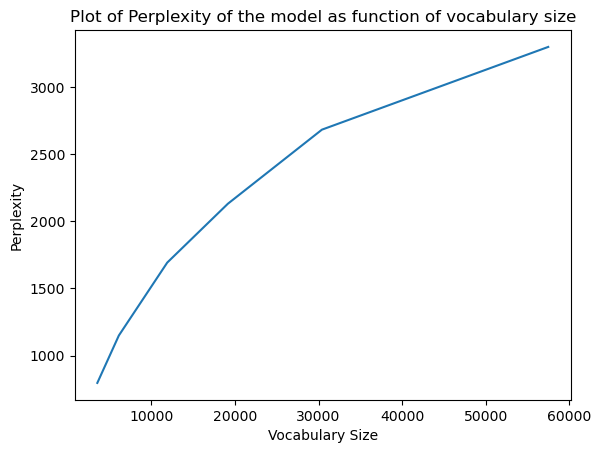

In [147]:
plt.plot(vocab_sizes, perplexities)
plt.title('Plot of Perplexity of the model as function of vocabulary size') 
plt.ylabel('Perplexity')
plt.xlabel('Vocabulary Size')
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

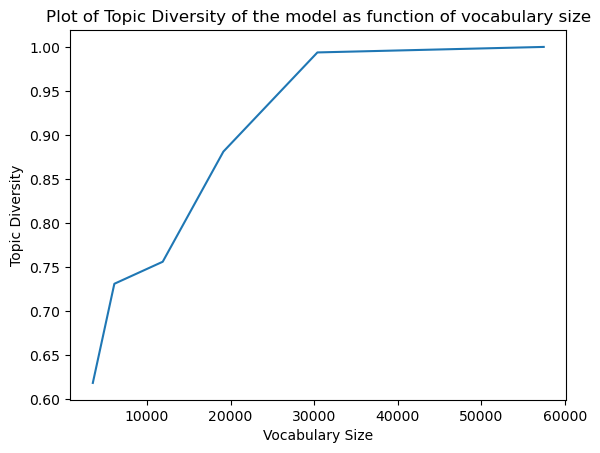

In [148]:
plt.plot(vocab_sizes, topic_diversities)
plt.title('Plot of Topic Diversity of the model as function of vocabulary size') 
plt.ylabel('Topic Diversity')
plt.xlabel('Vocabulary Size')
plt.show